In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.models import ResNetFeatureExtractor
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV, VOCDetectionFromLMDB
from torchlake.object_detection.models.yolov1 import YOLOV1Modified, YOLOLoss
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.plot import draw_pred
from torchlake.object_detection.utils.train import collate_fn
from torchlake.common.controller.trainer import DoNothingTrainer
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.controller.recorder import TrainRecorder

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# setting

In [3]:
artifact_path = Path('../../artifacts/yolov1')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = 2

In [6]:
CONTEXT = DetectorContext(
    detector_name="yolov1",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
)

# data

In [7]:
BATCH_SIZE = 64

In [8]:
IMAGE_SIZE = 448

In [9]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(p=0.5),
        # A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        # A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.augmentations.geometric.resize.SmallestMaxSize(input_size),
        A.RandomSizedBBoxSafeCrop(IMAGE_SIZE, IMAGE_SIZE, erosion_rate=0.1),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [10]:
# train_dataset = VOCDetectionFromCSV(
#     data_path,
#     data_path.joinpath("voc_trainval.csv"),
#     transform=transform,
# )

In [11]:
train_dataset = VOCDetectionFromLMDB(
    data_path.joinpath("voc").as_posix(),
    transform=transform,
)

In [12]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 448, 448]) 1


In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [14]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([64, 3, 448, 448]) 64


# model

In [15]:
backbone = ResNetFeatureExtractor("resnet34", "block", trainable=True)
backbone.fix_target_layers(["4_1"])

In [16]:
model = YOLOV1Modified(backbone, CONTEXT, dropout_prob=0).to(CONTEXT.device)

In [17]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
YOLOV1Modified                                     --
├─ResNetFeatureExtractor: 1-1                      --
│    └─ResNet: 2-1                                 --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    │    └─MaxPool2d: 3-4                         --
│    │    └─Module: 3-5                            221,952
│    │    └─Module: 3-6                            1,116,416
│    │    └─Module: 3-7                            6,822,400
│    │    └─Module: 3-8                            13,114,368
│    │    └─AdaptiveAvgPool2d: 3-9                 --
│    └─ImageNetNormalization: 2-2                  --
├─Sequential: 1-2                                  --
│    └─Conv2dNormActivation: 2-3                   --
│    │    └─Conv2d: 3-10                           4,718,592
│    │    └─BatchNorm2d: 3-11          

# train

In [18]:
DEBUG = True

In [19]:
EPOCH = 100

In [20]:
recorder = TrainRecorder(total_epoch=EPOCH, num_loss=1 if not DEBUG else 6)
recorder.increment_data_size(len(train_dataset))

In [21]:
trainer = DoNothingTrainer(device=CONTEXT.device, validate_interval=10, checkpoint_interval=10)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = YOLOLoss(CONTEXT, return_all_loss=DEBUG)

In [23]:
scaler = torch.amp.GradScaler()

In [24]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [25]:
def validate_func(model):
    from torchlake.object_detection.models.yolov1.decode import Decoder
    from torchlake.object_detection.configs.schema import InferenceCfg
    from torchlake.object_detection.controller.predictor import Predictor
    from torchlake.object_detection.controller.evaluator import Evaluator
    
    decoder = Decoder(CONTEXT)
    inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)
    
    predictor = Predictor(CONTEXT)
    predictor.set_postprocess_cfg(decoder, inferCfg)
    
    test_transform = A.Compose(
        [
            A.Resize(IMAGE_SIZE, IMAGE_SIZE),
            A.Normalize(0, 1),
            ToTensorV2(),
        ]
    )
    
    test_dataset = VOCDetectionFromCSV(
        data_path,
        data_path.joinpath("voc_test.csv"),
        transform=test_transform,
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        # num_workers=get_num_workers(),
        collate_fn=collate_fn,
    )
    
    evaluator = Evaluator(CONTEXT)
    
    result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES, verbose=False)
    
    print("validation mAP:", result_table['all'])

In [26]:
manager = WeightManager(artifact_path.joinpath("yolov1.{backbone_name}.{epoch}.pth").as_posix())
optimizer_manager = WeightManager(artifact_path.joinpath("adam.{lr}.{decay}.{epoch}.pth").as_posix())

In [27]:
def checkpoint_func(model, optimizer):
    filename = manager.get_filename(
        backbone_name=model.foot.network_name,
        epoch=recorder.current_epoch,
    )
    manager.save_weight(model.state_dict(), filename)
    
    param_group = optimizer.param_groups[0]
    filename = optimizer_manager.get_filename(
        lr=param_group['lr'],
        decay=param_group['weight_decay'],
        epoch=recorder.current_epoch,
    )
    optimizer_manager.save_weight(optimizer.state_dict(), filename)

In [28]:
_ = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler,
    scaler=scaler,
    recorder=recorder,
    validate_func=validate_func,
    checkpoint_func=checkpoint_func, 
)

Enable AMP: True
Training...


100%|██████████| 258/258 [03:25<00:00,  1.25it/s]


------------------------------------
Epoch 1
------------------------------------
3.6226855982078083 (0%)
1.3372646497964187 (0%)
0.4807336271497021 (0%)
0.3867121499929173 (0%)
0.027829538381436043 (0%)
0.3038388610743271 (0%)


100%|██████████| 258/258 [03:26<00:00,  1.25it/s]


------------------------------------
Epoch 2
------------------------------------
1.512514224204259 (-58%)
0.633776558309111 (-53%)
0.23627010672973012 (-51%)
0.4225010630169861 (9%)
0.010508008380936223 (-62%)
0.05711230121921626 (-81%)


100%|██████████| 258/258 [03:26<00:00,  1.25it/s]


------------------------------------
Epoch 3
------------------------------------
1.3435067718507698 (-11%)
0.5062699591916866 (-20%)
0.2682740790744136 (14%)
0.427511512185215 (1%)
0.008793456407769067 (-16%)
0.04632419550514644 (-19%)


100%|██████████| 258/258 [03:26<00:00,  1.25it/s]


------------------------------------
Epoch 4
------------------------------------
1.2488778398790483 (-7%)
0.4390535205377564 (-13%)
0.2959806140214896 (10%)
0.4217028004490324 (-1%)
0.00803587068950192 (-9%)
0.03999037206313391 (-14%)


100%|██████████| 258/258 [03:26<00:00,  1.25it/s]


------------------------------------
Epoch 5
------------------------------------
1.1839002379117276 (-5%)
0.39037918671402894 (-11%)
0.3140196288275176 (6%)
0.4123503995167872 (-2%)
0.007564161549262155 (-6%)
0.03726800565856163 (-7%)


100%|██████████| 258/258 [03:25<00:00,  1.26it/s]


------------------------------------
Epoch 6
------------------------------------
1.1300427117208567 (-5%)
0.35649156348596245 (-9%)
0.3325942518141945 (6%)
0.39922025243895054 (-3%)
0.007188277018480051 (-5%)
0.03441847649868662 (-8%)


100%|██████████| 258/258 [03:19<00:00,  1.29it/s]


------------------------------------
Epoch 7
------------------------------------
1.0862919623798049 (-4%)
0.3269076616726184 (-8%)
0.3488123101285199 (5%)
0.39394897371971677 (-1%)
0.006752873455950166 (-6%)
0.031452960315755285 (-9%)


100%|██████████| 258/258 [03:19<00:00,  1.29it/s]


------------------------------------
Epoch 8
------------------------------------
1.0446787282106964 (-4%)
0.2959029799998329 (-9%)
0.3625849550436303 (4%)
0.38872536212164444 (-1%)
0.006349475922076612 (-6%)
0.02940210537797814 (-7%)


100%|██████████| 258/258 [03:19<00:00,  1.30it/s]


------------------------------------
Epoch 9
------------------------------------
1.0010278819442973 (-4%)
0.262912739238655 (-11%)
0.37645486148633484 (4%)
0.3835968963473693 (-1%)
0.005980901417865627 (-6%)
0.027277261441902463 (-7%)


100%|██████████| 258/258 [03:19<00:00,  1.29it/s]


------------------------------------
Epoch 10
------------------------------------
0.988836128382832 (-1%)
0.25617660855852253 (-3%)
0.383402197665372 (2%)
0.37968294031778055 (-1%)
0.00574703056854349 (-4%)
0.026508065881516524 (-3%)
Validating...


100%|██████████| 78/78 [01:10<00:00,  1.10it/s]


validation mAP: AP@0.5    0.484306
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov1\yolov1.resnet34.10.pth, model size is 216.44MiB
Save weight to ..\..\artifacts\yolov1\adam.0.0001.0.10.pth, model size is 432.61MiB


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 11
------------------------------------
1.2713028697634479 (29%)
0.4998291281370028 (95%)
0.3424832752180074 (-11%)
0.3800182367882248 (0%)
0.00637945582136187 (11%)
0.03766331816143114 (42%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 12
------------------------------------
1.1013602749486464 (-13%)
0.3494571848626107 (-30%)
0.3707174803942585 (8%)
0.3916631807741329 (3%)
0.005598986122184822 (-12%)
0.029377247435716285 (-22%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 13
------------------------------------
0.9362773025196472 (-15%)
0.20749545211151255 (-41%)
0.4137970212939054 (12%)
0.39580480296563814 (1%)
0.004703978557909631 (-16%)
0.02051172823453914 (-30%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 14
------------------------------------
0.9008277061950564 (-4%)
0.1784165759049445 (-14%)
0.4292623376883765 (4%)
0.3925855803810918 (-1%)
0.004465609341436668 (-5%)
0.01857326768415658 (-9%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 15
------------------------------------
0.8873148409882798 (-2%)
0.16874715975206594 (-5%)
0.4343446472621555 (1%)
0.39098103138177615 (0%)
0.004374962769803029 (-2%)
0.01770790297886692 (-5%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 16
------------------------------------
0.8740471634833978 (-1%)
0.15935782030423773 (-6%)
0.43780029579906127 (1%)
0.38797374368326193 (-1%)
0.0043049965907523205 (-2%)
0.017258093734283365 (-3%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 17
------------------------------------
0.8655436173946605 (-1%)
0.1521805703233041 (-5%)
0.44337579599140436 (1%)
0.3869116058681504 (0%)
0.004242726089435651 (-1%)
0.01670998254576289 (-3%)


100%|██████████| 258/258 [03:17<00:00,  1.30it/s]


------------------------------------
Epoch 18
------------------------------------
0.8550422091792621 (-1%)
0.14458288295658966 (-5%)
0.4462377817765744 (1%)
0.38463723511863257 (-1%)
0.004183266827991151 (-1%)
0.016357373041758307 (-2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 19
------------------------------------
0.8464596185804624 (-1%)
0.13879598942301968 (-4%)
0.44956560326763423 (1%)
0.3845342820839222 (0%)
0.004149212505938271 (-1%)
0.015520096498633094 (-5%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 20
------------------------------------
0.8447170426972174 (0%)
0.13737930248067584 (-1%)
0.4525342169978255 (1%)
0.38320647829659765 (0%)
0.004133623416355662 (0%)
0.015439207453316015 (-1%)
Validating...


100%|██████████| 78/78 [01:12<00:00,  1.07it/s]


validation mAP: AP@0.5    0.587388
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov1\yolov1.resnet34.20.pth, model size is 216.44MiB
Save weight to ..\..\artifacts\yolov1\adam.1.0000000000000002e-06.0.20.pth, model size is 432.62MiB


100%|██████████| 258/258 [03:19<00:00,  1.30it/s]


------------------------------------
Epoch 21
------------------------------------
0.8426319876219035 (0%)
0.13576446351065208 (-1%)
0.4537023084846899 (0%)
0.3833634161774852 (0%)
0.0040785852855918965 (-1%)
0.015252005603045363 (-1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 22
------------------------------------
0.8421717916800602 (0%)
0.1349872982715899 (-1%)
0.45530114650121295 (0%)
0.3825710145204595 (0%)
0.004091331927583741 (0%)
0.015301248779268643 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 23
------------------------------------
0.8397794201124699 (0%)
0.13472013820385212 (0%)
0.45394144558948346 (0%)
0.3818562686079601 (0%)
0.004070621956857583 (-1%)
0.015175836043850211 (-1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 24
------------------------------------
0.8341954120458291 (-1%)
0.13068832271330003 (-3%)
0.45631353952079295 (1%)
0.380663333879224 (0%)
0.0040453199832203605 (-1%)
0.014892076743375815 (-2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 25
------------------------------------
0.8330020262650384 (0%)
0.12973098022816346 (-1%)
0.45519285782263236 (0%)
0.3811611998125146 (0%)
0.004068339972451089 (1%)
0.01483434402152539 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 26
------------------------------------
0.8358253228701132 (0%)
0.1305646901548137 (1%)
0.45590388722293296 (0%)
0.38252781608747016 (0%)
0.004059376406760369 (0%)
0.014896798064345556 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 27
------------------------------------
0.8369618719434121 (0%)
0.13171665154658133 (1%)
0.4553333183594192 (0%)
0.3817024273596088 (0%)
0.004050505906028347 (0%)
0.015124721052740134 (2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 28
------------------------------------
0.8353180036279173 (0%)
0.13360914991857176 (1%)
0.4543409971562506 (0%)
0.38074983676663554 (0%)
0.0040468839461130285 (0%)
0.014710819953143803 (-3%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 29
------------------------------------
0.8370263728481222 (0%)
0.13340471122324066 (0%)
0.45464128143124344 (0%)
0.3798544206516124 (0%)
0.0040778461480225695 (1%)
0.015211474631864225 (3%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 30
------------------------------------
0.8325086027450428 (-1%)
0.12910105494831733 (-3%)
0.4551454599037192 (0%)
0.3808502240826602 (0%)
0.004066225539002274 (0%)
0.014930692556566871 (-2%)
Validating...


100%|██████████| 78/78 [01:12<00:00,  1.08it/s]


validation mAP: AP@0.5    0.588056
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov1\yolov1.resnet34.30.pth, model size is 216.44MiB
Save weight to ..\..\artifacts\yolov1\adam.1.0000000000000004e-08.0.30.pth, model size is 432.62MiB


100%|██████████| 258/258 [03:19<00:00,  1.29it/s]


------------------------------------
Epoch 31
------------------------------------
0.8352083548787327 (0%)
0.1319555243180457 (2%)
0.4552043995232923 (0%)
0.3809219577234535 (0%)
0.004043653664988817 (-1%)
0.014902080292356281 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 32
------------------------------------
0.8358886132866347 (0%)
0.13206000123799844 (0%)
0.45510175856036605 (0%)
0.3817238900158873 (0%)
0.0040497279503534074 (0%)
0.014861040872055614 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 33
------------------------------------
0.8361077987710541 (0%)
0.1310526799611127 (-1%)
0.4539707909393264 (0%)
0.38305118547653577 (0%)
0.00406758164730715 (0%)
0.014936126232449722 (1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 34
------------------------------------
0.8318286566394065 (-1%)
0.12858776832720237 (-2%)
0.45639584545757556 (1%)
0.3806985790913477 (-1%)
0.004074155028388837 (0%)
0.014794722254359398 (-1%)


100%|██████████| 258/258 [03:19<00:00,  1.30it/s]


------------------------------------
Epoch 35
------------------------------------
0.8366404850240506 (1%)
0.13080473333951903 (2%)
0.45629483192365045 (0%)
0.38335252443430795 (1%)
0.004059047577359669 (0%)
0.014808115498348774 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 36
------------------------------------
0.8360635203023337 (0%)
0.13167643140834678 (1%)
0.45486008201176403 (0%)
0.38199030044294763 (0%)
0.0040826294567785065 (1%)
0.014910720081230233 (1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 37
------------------------------------
0.8353816084210357 (0%)
0.1307724676321773 (-1%)
0.4568802986423903 (0%)
0.38152283534896486 (0%)
0.004022519839911235 (-1%)
0.014906711966874308 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 38
------------------------------------
0.8372062511166356 (0%)
0.1309736548258916 (0%)
0.45723780118679436 (0%)
0.38379468589986976 (1%)
0.004055289529895548 (1%)
0.014708512499644884 (-1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 39
------------------------------------
0.8369051087594779 (0%)
0.13013106427893634 (-1%)
0.456622629336782 (0%)
0.3843091421131352 (0%)
0.004027166409288228 (-1%)
0.014803550971338716 (1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 40
------------------------------------
0.8362260841183857 (0%)
0.1301224117919791 (0%)
0.45647982653300434 (0%)
0.38149359521387016 (-1%)
0.004057709123388058 (1%)
0.015216323223569795 (3%)
Validating...


100%|██████████| 78/78 [01:13<00:00,  1.07it/s]


validation mAP: AP@0.5    0.588503
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov1\yolov1.resnet34.40.pth, model size is 216.44MiB
Save weight to ..\..\artifacts\yolov1\adam.1.0000000000000004e-08.0.40.pth, model size is 432.62MiB


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 41
------------------------------------
0.8328777149821125 (0%)
0.1289587121709625 (-1%)
0.4555876375029767 (0%)
0.3809216136147585 (0%)
0.004044144463376348 (0%)
0.014996570326411737 (-1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 42
------------------------------------
0.8353293880250366 (0%)
0.13209830325259567 (2%)
0.455937443467528 (0%)
0.3827779498044678 (0%)
0.0040031768335229215 (-1%)
0.014493706517907826 (-3%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 43
------------------------------------
0.833570019268685 (0%)
0.12969954562226085 (-2%)
0.45649090727091085 (0%)
0.3805019175147055 (-1%)
0.0040561983656806876 (1%)
0.014968422341725586 (3%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 44
------------------------------------
0.833871988132061 (0%)
0.13037275167456797 (1%)
0.45661369576338023 (0%)
0.3814904479906714 (0%)
0.004046741910164005 (0%)
0.014693645831429552 (-2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 45
------------------------------------
0.8382770433922008 (1%)
0.13318756626247383 (2%)
0.4567670366366637 (0%)
0.38148019963625707 (0%)
0.004034152334027834 (0%)
0.015010999314093984 (2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 46
------------------------------------
0.8341062019241666 (0%)
0.12959472661032498 (-3%)
0.45557901000884354 (0%)
0.3816834895115706 (0%)
0.004048045990899368 (0%)
0.014959650189917902 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 47
------------------------------------
0.8329084611977633 (0%)
0.13060170763907833 (1%)
0.45669885298527396 (0%)
0.3791904685706297 (-1%)
0.004052630611203832 (0%)
0.01490074135401365 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 48
------------------------------------
0.8340187088887603 (0%)
0.1301384656265505 (0%)
0.45608815754456034 (0%)
0.38203845526270175 (1%)
0.004042661613722553 (0%)
0.014716880334899415 (-1%)


100%|██████████| 258/258 [03:20<00:00,  1.29it/s]


------------------------------------
Epoch 49
------------------------------------
0.8353069144774404 (0%)
0.13029107535528595 (0%)
0.4558227769082911 (0%)
0.3824195466540847 (0%)
0.0040303278304998835 (0%)
0.014906652805185923 (1%)


100%|██████████| 258/258 [03:21<00:00,  1.28it/s]


------------------------------------
Epoch 50
------------------------------------
0.8345633460621014 (0%)
0.12948512948896868 (-1%)
0.4571215108862586 (0%)
0.3826181017504769 (0%)
0.004060348685245401 (1%)
0.014719523295456739 (-1%)
Validating...


100%|██████████| 78/78 [01:14<00:00,  1.04it/s]


validation mAP: AP@0.5    0.588178
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov1\yolov1.resnet34.50.pth, model size is 216.44MiB
Save weight to ..\..\artifacts\yolov1\adam.1.0000000000000004e-08.0.50.pth, model size is 432.62MiB


100%|██████████| 258/258 [03:22<00:00,  1.27it/s]


------------------------------------
Epoch 51
------------------------------------
0.8362801285439998 (0%)
0.1311446769339362 (1%)
0.45649211072941953 (0%)
0.38167193628684215 (0%)
0.004037093711247958 (-1%)
0.015006398127940569 (2%)


100%|██████████| 258/258 [03:27<00:00,  1.24it/s]


------------------------------------
Epoch 52
------------------------------------
0.834794666621485 (0%)
0.13029326191770146 (-1%)
0.45584392403556556 (0%)
0.38167755288751076 (0%)
0.004031348479463214 (0%)
0.014949029103901935 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 53
------------------------------------
0.8327179109500646 (0%)
0.13039317415398874 (0%)
0.4573998473416742 (0%)
0.3796919558273111 (-1%)
0.004042418078636952 (0%)
0.014744153568934939 (-1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 54
------------------------------------
0.8311698650364484 (0%)
0.1286559361762117 (-1%)
0.45596227115190635 (0%)
0.3810917780151697 (0%)
0.004043693727333734 (0%)
0.014644509488726289 (-1%)


100%|██████████| 258/258 [03:17<00:00,  1.30it/s]


------------------------------------
Epoch 55
------------------------------------
0.8392542904218905 (1%)
0.132142451773035 (3%)
0.4568279185227978 (0%)
0.38301373225282337 (1%)
0.004048298039390823 (0%)
0.015088530604079168 (3%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 56
------------------------------------
0.8360903584757617 (0%)
0.13116112922039008 (-1%)
0.45757301825640395 (0%)
0.3816005952710739 (0%)
0.004016053223925397 (-1%)
0.014892371813557055 (-1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 57
------------------------------------
0.832696362785195 (0%)
0.12968437265870117 (-1%)
0.45638952024191426 (0%)
0.3815053675111475 (0%)
0.00405266960127016 (1%)
0.014609702230832293 (-2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 58
------------------------------------
0.8337064923624153 (0%)
0.13104692453862993 (1%)
0.4560625909368881 (0%)
0.38005214336451243 (0%)
0.004054389157998773 (0%)
0.01486083626581473 (2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 59
------------------------------------
0.8302175643890474 (0%)
0.12910840082194497 (-1%)
0.455749964384174 (0%)
0.38032677517752017 (0%)
0.004003300431862132 (-1%)
0.014578181534733666 (-2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 60
------------------------------------
0.8362728746036319 (1%)
0.13075953055404768 (1%)
0.4568899961463144 (0%)
0.3814367581606558 (0%)
0.004033167774306634 (1%)
0.01509314928881085 (4%)
Validating...


100%|██████████| 78/78 [01:13<00:00,  1.07it/s]


validation mAP: AP@0.5    0.588117
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov1\yolov1.resnet34.60.pth, model size is 216.44MiB
Save weight to ..\..\artifacts\yolov1\adam.1.0000000000000004e-08.0.60.pth, model size is 432.62MiB


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 61
------------------------------------
0.8367806515818413 (0%)
0.13203896654242078 (1%)
0.4563966499528211 (0%)
0.3811972335014276 (0%)
0.00405628309099489 (1%)
0.015012941989399696 (-1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 62
------------------------------------
0.8343026829186494 (0%)
0.13179672081285665 (0%)
0.45569179480288036 (0%)
0.38157440071689036 (0%)
0.004046806183857296 (0%)
0.014570326941891037 (-3%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 63
------------------------------------
0.8348223783193301 (0%)
0.12928968540138866 (-2%)
0.4567084461963758 (0%)
0.38237155351701585 (0%)
0.004056852498837277 (0%)
0.014904530359808314 (2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 64
------------------------------------
0.8362577826830851 (0%)
0.13215789008548215 (2%)
0.45699536335820506 (0%)
0.3814321794176268 (0%)
0.0040425403571101495 (0%)
0.014791465536301018 (-1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 65
------------------------------------
0.8379859207519333 (0%)
0.1328344976323643 (1%)
0.45678664495502636 (0%)
0.38194027215532267 (0%)
0.004068349138587402 (1%)
0.014895216483132348 (1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 66
------------------------------------
0.8368772891963489 (0%)
0.13154889008738277 (-1%)
0.4584216989712315 (0%)
0.3818628717841615 (0%)
0.0040381986092573275 (-1%)
0.014812736797603582 (-1%)


100%|██████████| 258/258 [03:19<00:00,  1.30it/s]


------------------------------------
Epoch 67
------------------------------------
0.8313924316826654 (-1%)
0.12808497549435802 (-3%)
0.4560941452202451 (-1%)
0.3815874497657541 (0%)
0.004025104230289035 (0%)
0.014709482237432863 (-1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 68
------------------------------------
0.8389965700646569 (1%)
0.13342802369423876 (4%)
0.45710004223746376 (0%)
0.38123573553064455 (0%)
0.004064682565220291 (1%)
0.015091875207567489 (3%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 69
------------------------------------
0.8383445640639099 (0%)
0.1327212367070188 (-1%)
0.455421248157034 (0%)
0.38231133172954423 (0%)
0.004047074137364374 (0%)
0.015073200396400704 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 70
------------------------------------
0.8355458685800203 (0%)
0.1304540273595969 (-2%)
0.45769029271241785 (0%)
0.38242181309270207 (0%)
0.004016538881497847 (-1%)
0.014748437095931573 (-2%)
Validating...


100%|██████████| 78/78 [01:13<00:00,  1.07it/s]


validation mAP: AP@0.5    0.588247
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov1\yolov1.resnet34.70.pth, model size is 216.44MiB
Save weight to ..\..\artifacts\yolov1\adam.1.0000000000000004e-08.0.70.pth, model size is 432.62MiB


100%|██████████| 258/258 [03:19<00:00,  1.30it/s]


------------------------------------
Epoch 71
------------------------------------
0.8376888021386484 (0%)
0.1329559240231131 (2%)
0.45611758264096014 (0%)
0.38139214791399373 (0%)
0.0040748384398828046 (1%)
0.014981548571239444 (2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 72
------------------------------------
0.8338184493825875 (0%)
0.13051457748219483 (-2%)
0.4553787369042695 (0%)
0.3822911118288484 (0%)
0.004010434438185305 (-2%)
0.014654243977709003 (-2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 73
------------------------------------
0.8357672521653307 (0%)
0.13113242022242547 (0%)
0.4561873854240202 (0%)
0.38140914349547045 (0%)
0.004065252651902355 (1%)
0.014961146291350532 (2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 74
------------------------------------
0.8356093608982277 (0%)
0.13010975917108344 (-1%)
0.4558576555397852 (0%)
0.382874109054878 (0%)
0.004070651001112319 (0%)
0.014868681801459501 (-1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 75
------------------------------------
0.8358300816190978 (0%)
0.13100617530158498 (1%)
0.4567642592208334 (0%)
0.382112425840497 (0%)
0.0040475450612347565 (-1%)
0.014818325182309886 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 76
------------------------------------
0.8356652316582699 (0%)
0.13106159339620368 (0%)
0.457355336202004 (0%)
0.38033473715667765 (0%)
0.004053945435432428 (0%)
0.015064301469032019 (2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 77
------------------------------------
0.8332710936814084 (0%)
0.13116840827602622 (0%)
0.45706093046976504 (0%)
0.37992329701477856 (0%)
0.004039874863396971 (0%)
0.014689909348379234 (-2%)


100%|██████████| 258/258 [03:17<00:00,  1.30it/s]


------------------------------------
Epoch 78
------------------------------------
0.8352574667724034 (0%)
0.13018175025957457 (-1%)
0.4555229221353446 (0%)
0.38189018382729967 (1%)
0.004030398758442611 (0%)
0.015054415451148564 (2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 79
------------------------------------
0.8354069102056066 (0%)
0.13082909401100826 (0%)
0.45778556057610387 (0%)
0.38171006470574737 (0%)
0.004032925324104075 (0%)
0.014762068380366552 (-2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 80
------------------------------------
0.8323609188066687 (0%)
0.12966913268268104 (-1%)
0.45632585160545464 (0%)
0.3795457977908924 (-1%)
0.004055650741929671 (1%)
0.014940962028837617 (1%)
Validating...


100%|██████████| 78/78 [01:13<00:00,  1.06it/s]


validation mAP: AP@0.5    0.588096
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov1\yolov1.resnet34.80.pth, model size is 216.44MiB
Save weight to ..\..\artifacts\yolov1\adam.1.0000000000000004e-08.0.80.pth, model size is 432.62MiB


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 81
------------------------------------
0.8341067285741119 (0%)
0.12944695747307028 (0%)
0.4571680207604279 (0%)
0.38095540708231096 (0%)
0.004041287333401631 (0%)
0.014982783227562947 (0%)


100%|██████████| 258/258 [03:17<00:00,  1.30it/s]


------------------------------------
Epoch 82
------------------------------------
0.835386083447446 (0%)
0.13192940742168152 (2%)
0.4571893687522213 (0%)
0.3804669315941307 (0%)
0.004054489253539778 (0%)
0.014824522732896079 (-1%)


100%|██████████| 258/258 [03:17<00:00,  1.30it/s]


------------------------------------
Epoch 83
------------------------------------
0.8359163985080383 (0%)
0.13215979053407884 (0%)
0.4566753517212188 (0%)
0.3804124906253083 (0%)
0.004069552167644169 (0%)
0.01493173616363609 (1%)


100%|██████████| 258/258 [03:17<00:00,  1.30it/s]


------------------------------------
Epoch 84
------------------------------------
0.8336836995981106 (0%)
0.1311868337495587 (-1%)
0.4563985493498467 (0%)
0.37941843608694636 (0%)
0.004082285303067213 (0%)
0.014893545570578662 (0%)


100%|██████████| 258/258 [03:17<00:00,  1.30it/s]


------------------------------------
Epoch 85
------------------------------------
0.8329224968221595 (0%)
0.12943493645037493 (-1%)
0.45641798803391576 (0%)
0.3812054153598191 (0%)
0.004027251501932122 (-1%)
0.014787378429855138 (-1%)


100%|██████████| 258/258 [03:17<00:00,  1.30it/s]


------------------------------------
Epoch 86
------------------------------------
0.8329290842103868 (0%)
0.1310553146225399 (1%)
0.455575660883959 (0%)
0.3798394800420903 (0%)
0.004042915857188989 (0%)
0.01480637592215183 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 87
------------------------------------
0.8342994107745443 (0%)
0.13004979739541497 (-1%)
0.45700226581447434 (0%)
0.3807198988491729 (0%)
0.004049323239461018 (0%)
0.014956392339259626 (1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 88
------------------------------------
0.8330642820506591 (0%)
0.12982690685083906 (0%)
0.4558982011321291 (0%)
0.38135111531450083 (0%)
0.00405650104084704 (0%)
0.01473093119807621 (-2%)


100%|██████████| 258/258 [03:17<00:00,  1.30it/s]


------------------------------------
Epoch 89
------------------------------------
0.8354424995264254 (0%)
0.12953683746724629 (0%)
0.45731679775672973 (0%)
0.38349485037211734 (1%)
0.003984228182570769 (-2%)
0.014766254339914768 (0%)


100%|██████████| 258/258 [03:17<00:00,  1.30it/s]


------------------------------------
Epoch 90
------------------------------------
0.8346495064541873 (0%)
0.12950477963970133 (0%)
0.45671007397109886 (0%)
0.382965204859924 (0%)
0.004025282882166141 (1%)
0.014739614200407652 (0%)
Validating...


100%|██████████| 78/78 [01:12<00:00,  1.07it/s]


validation mAP: AP@0.5    0.588259
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov1\yolov1.resnet34.90.pth, model size is 216.44MiB
Save weight to ..\..\artifacts\yolov1\adam.1.0000000000000004e-08.0.90.pth, model size is 432.62MiB


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 91
------------------------------------
0.8299822115579781 (-1%)
0.12799410848529397 (-1%)
0.4573574077686174 (0%)
0.3802189277555349 (-1%)
0.004016149924367687 (0%)
0.014601945250453947 (-1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 92
------------------------------------
0.8381530805971174 (1%)
0.13245831244042702 (3%)
0.45705770615054575 (0%)
0.38161140715245473 (0%)
0.004036286768038303 (1%)
0.015074614811992293 (3%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 93
------------------------------------
0.8354190266115784 (0%)
0.13153692573429593 (-1%)
0.4557476049463208 (0%)
0.38198978935049477 (0%)
0.0040313955237732775 (0%)
0.01477230625147977 (-2%)


100%|██████████| 258/258 [03:17<00:00,  1.30it/s]


------------------------------------
Epoch 94
------------------------------------
0.837595116529614 (0%)
0.13049590128813968 (-1%)
0.45705577344896153 (0%)
0.3834815069985357 (0%)
0.004008352572835398 (-1%)
0.015009611974662268 (2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 95
------------------------------------
0.8326629365320966 (-1%)
0.12859771398034148 (-1%)
0.4566339317977728 (0%)
0.3816725950026164 (0%)
0.00405283257861302 (1%)
0.014762299762061122 (-2%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 96
------------------------------------
0.8358622146411918 (0%)
0.13100468964744102 (2%)
0.4559192560668527 (0%)
0.38278908389881267 (0%)
0.004011471790746218 (-1%)
0.01481029019457474 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 97
------------------------------------
0.8334872914357428 (0%)
0.12964953492324624 (-1%)
0.457287815415055 (0%)
0.38152290034471337 (0%)
0.004050431697327279 (1%)
0.014683757759020711 (-1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 98
------------------------------------
0.8365643448098156 (0%)
0.13150536360736917 (1%)
0.45584901894163804 (0%)
0.38305682109191797 (0%)
0.004047758750782713 (0%)
0.014767771497981926 (1%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 99
------------------------------------
0.833916820908491 (0%)
0.1310570432832828 (0%)
0.45751383467229356 (0%)
0.38043161689187144 (-1%)
0.004033661636475902 (0%)
0.014700586916737582 (0%)


100%|██████████| 258/258 [03:18<00:00,  1.30it/s]


------------------------------------
Epoch 100
------------------------------------
0.8315484147944502 (0%)
0.12852316369146638 (-2%)
0.45627134080077497 (0%)
0.38112700882220746 (0%)
0.004007399567455171 (-1%)
0.014745114525022354 (0%)
Validating...


100%|██████████| 78/78 [01:13<00:00,  1.06it/s]


validation mAP: AP@0.5    0.587942
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov1\yolov1.resnet34.100.pth, model size is 216.44MiB
Save weight to ..\..\artifacts\yolov1\adam.1.0000000000000004e-08.0.100.pth, model size is 432.62MiB


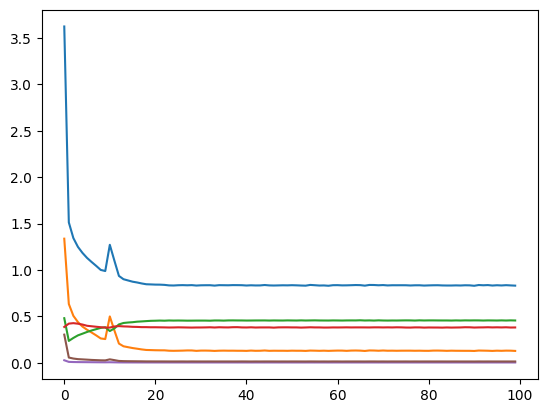

In [29]:
plt.plot(torch.Tensor(recorder.training_losses).T)

In [27]:
manager = WeightManager(artifact_path.joinpath("yolov1.{backbone_name}.{epoch}.pth").as_posix())

In [28]:
model_path = manager.get_filename(backbone_name="resnet34", epoch=40)

In [29]:
manager.load_weight(model_path, model)

# Inference

In [86]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [98]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [99]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [100]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [101]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [102]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [103]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [104]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [105]:
model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B, C+1, H, W
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/154 [00:00<?, ?it/s]


In [106]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

person: 0.44
person: 0.54
person: 0.60
person: 0.54
motorbike: 0.39
person: 0.50
horse: 0.65
bicycle: 0.51
boat: 0.45
bicycle: 0.47
person: 0.57
person: 0.32
aeroplane: 0.59
person: 0.42
person: 0.60
person: 0.49
person: 0.41
person: 0.51
person: 0.53
sheep: 0.37
chair: 0.37
person: 0.41
person: 0.52
person: 0.52
person: 0.43
tvmonitor: 0.51
person: 0.51
person: 0.52
chair: 0.39
tvmonitor: 0.40
person: 0.60
chair: 0.46
diningtable: 0.61
person: 0.41
person: 0.49
person: 0.36
person: 0.40
person: 0.35
person: 0.47
person: 0.35
cat: 0.64
car: 0.35
train: 0.48
person: 0.46
person: 0.54
person: 0.43
person: 0.57
tvmonitor: 0.36
person: 0.46
person: 0.55
person: 0.47
dog: 0.36
bird: 0.37
bird: 0.50
dog: 0.49
person: 0.31
car: 0.30
car: 0.56
cat: 0.53
cat: 0.48
motorbike: 0.57


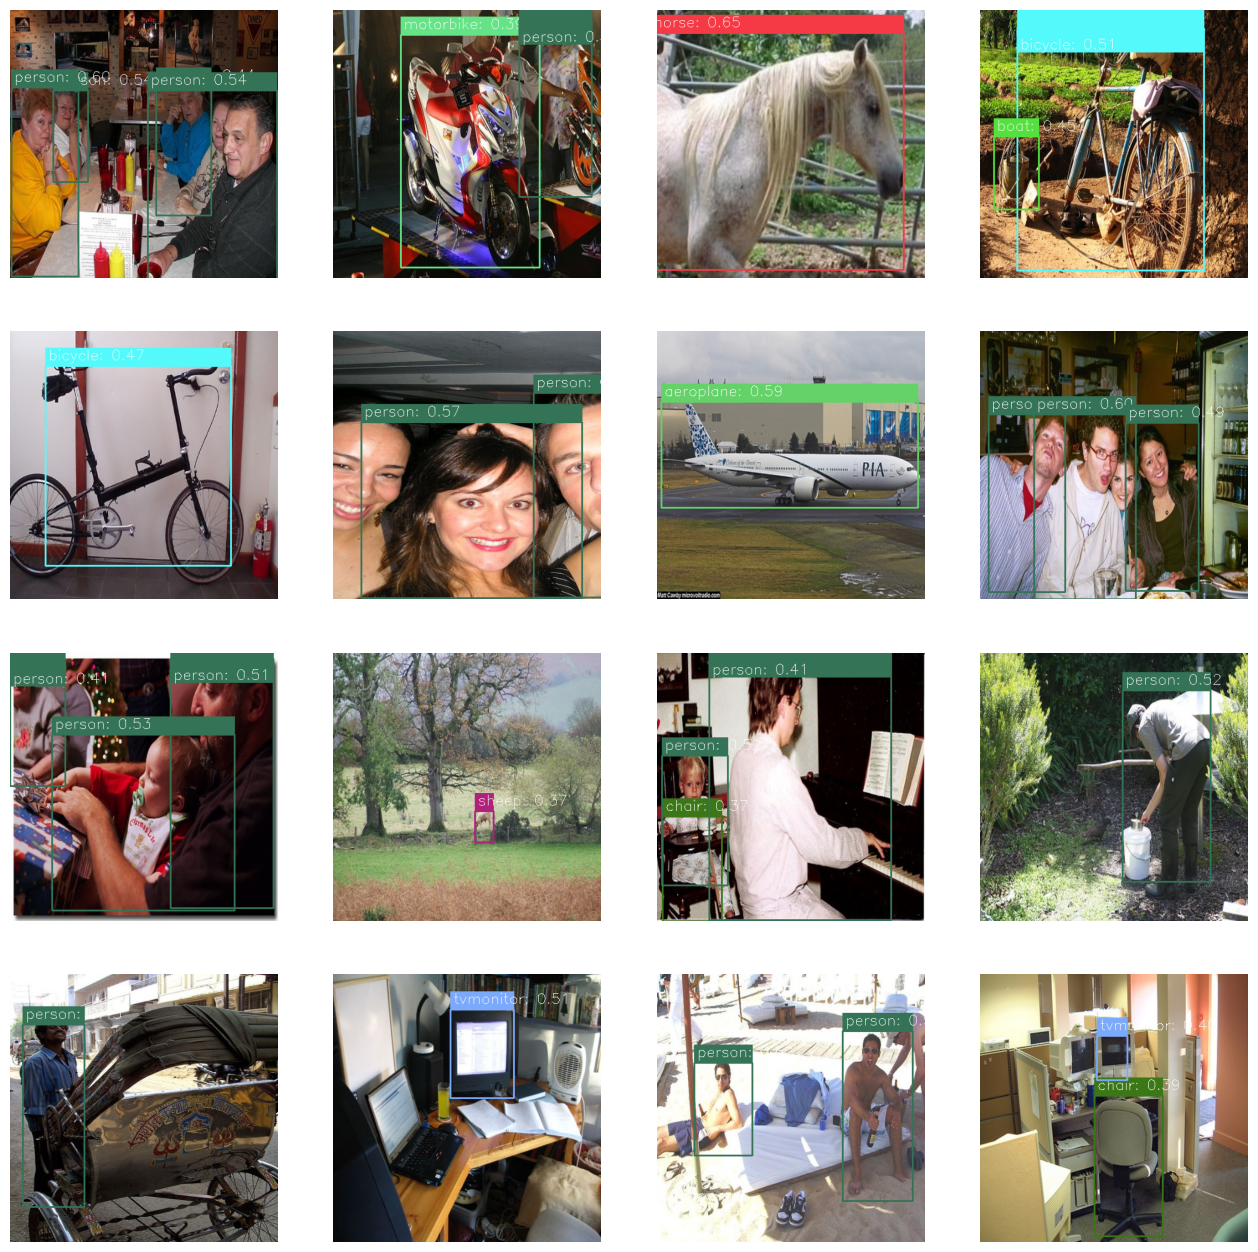

In [107]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [108]:
humans_img = "D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.49
person: 0.50
D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg 2
person: 0.37
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.61
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 1


In [ ]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

# evaluation

In [30]:
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [31]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [32]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [33]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [34]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [35]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [36]:
evaluator = Evaluator(CONTEXT)

In [37]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 78/78 [03:07<00:00,  2.41s/it]


       aeroplane   bicycle      bird      boat    bottle       bus       car  \
AP@0.5  0.621142  0.687455  0.611094  0.595141  0.499875  0.509766  0.586345   

             cat     chair      cow  ...       dog     horse motorbike  \
AP@0.5  0.599323  0.575929  0.57557  ...  0.594997  0.601369  0.602678   

          person pottedplant     sheep      sofa     train tvmonitor       all  
AP@0.5  0.592086    0.585135  0.584157  0.585551  0.588148  0.588246  0.588475  

[1 rows x 21 columns]


In [38]:
result_table.T

,AP@0.5
aeroplane,0.621142
bicycle,0.687455
bird,0.611094
boat,0.595141
bottle,0.499875
bus,0.509766
car,0.586345
cat,0.599323
chair,0.575929
cow,0.57557


# all epoch evaluation

In [ ]:
paths = artifact_path.glob("yolov1.resnet34.*.pth")
paths = sorted(list(paths), key=lambda p: int(p.as_posix().split(".")[-2]))

result_table = pd.DataFrame()
for path in paths:
    model.load_state_dict(torch.load(path))

    result = evaluator.run(
        predictor,
        model,
        test_loader,
        VOC_CLASS_NAMES,
        verbose=False,
    )
    
    result_table = pd.concat([result_table, result], axis=0, ignore_index=True)

100%|██████████| 155/155 [01:24<00:00,  1.84it/s]


In [ ]:
paths = artifact_path.glob("yolov1.resnet34.*.pth")
paths = list(map(lambda p: p.as_posix().split(".")[-2], paths))

In [77]:
result_table.index = paths

In [81]:
result_table.sort_index(key=lambda idx: idx.astype(int), inplace=True)

In [82]:
result_table

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,all
10,0.533396,0.581271,0.506655,0.495301,0.409754,0.416354,0.493076,0.504755,0.482534,0.476395,...,0.497488,0.560062,0.5591,0.560099,0.498874,0.498506,0.499119,0.500856,0.501462,0.503082
20,0.606645,0.601371,0.593302,0.570983,0.483302,0.490633,0.57226,0.585456,0.563773,0.563012,...,0.581154,0.588807,0.588478,0.582781,0.569797,0.570853,0.571789,0.575825,0.575161,0.570423
30,0.626228,0.619107,0.605342,0.58993,0.50172,0.508024,0.59085,0.598381,0.576773,0.576782,...,0.593562,0.599436,0.600797,0.594433,0.58737,0.588267,0.588865,0.590951,0.591845,0.585705
40,0.627027,0.620746,0.606723,0.589857,0.502025,0.508,0.591895,0.600905,0.576668,0.576752,...,0.595036,0.600585,0.601567,0.594243,0.587339,0.588086,0.588722,0.590857,0.591601,0.586201
50,0.626653,0.619459,0.604627,0.590292,0.501404,0.507225,0.590931,0.600093,0.575584,0.575874,...,0.594204,0.59958,0.600522,0.594915,0.587965,0.588774,0.589349,0.591607,0.592814,0.585908
60,0.62812,0.62085,0.607059,0.590953,0.50316,0.508762,0.591996,0.599981,0.577179,0.578179,...,0.594602,0.600649,0.601972,0.594853,0.587569,0.588273,0.588796,0.590612,0.592007,0.586618
70,0.628731,0.620832,0.607127,0.592773,0.503701,0.509607,0.593365,0.601925,0.578477,0.579026,...,0.596603,0.601601,0.60261,0.595765,0.58871,0.58941,0.589901,0.59232,0.593361,0.587724
80,0.627666,0.621174,0.6074,0.591849,0.502506,0.509342,0.592496,0.601193,0.578358,0.578399,...,0.596318,0.6019,0.602884,0.596025,0.589206,0.589918,0.59067,0.592804,0.593723,0.587587
90,0.627616,0.62205,0.60832,0.593961,0.503488,0.508931,0.59376,0.600881,0.578878,0.578909,...,0.595716,0.601382,0.602389,0.596496,0.58976,0.590677,0.591174,0.59367,0.594735,0.588035
100,0.627994,0.619842,0.605395,0.589746,0.500888,0.50754,0.590251,0.599285,0.577817,0.577702,...,0.594428,0.599706,0.60133,0.594605,0.587831,0.588566,0.589088,0.591556,0.592492,0.586099


<Axes: >

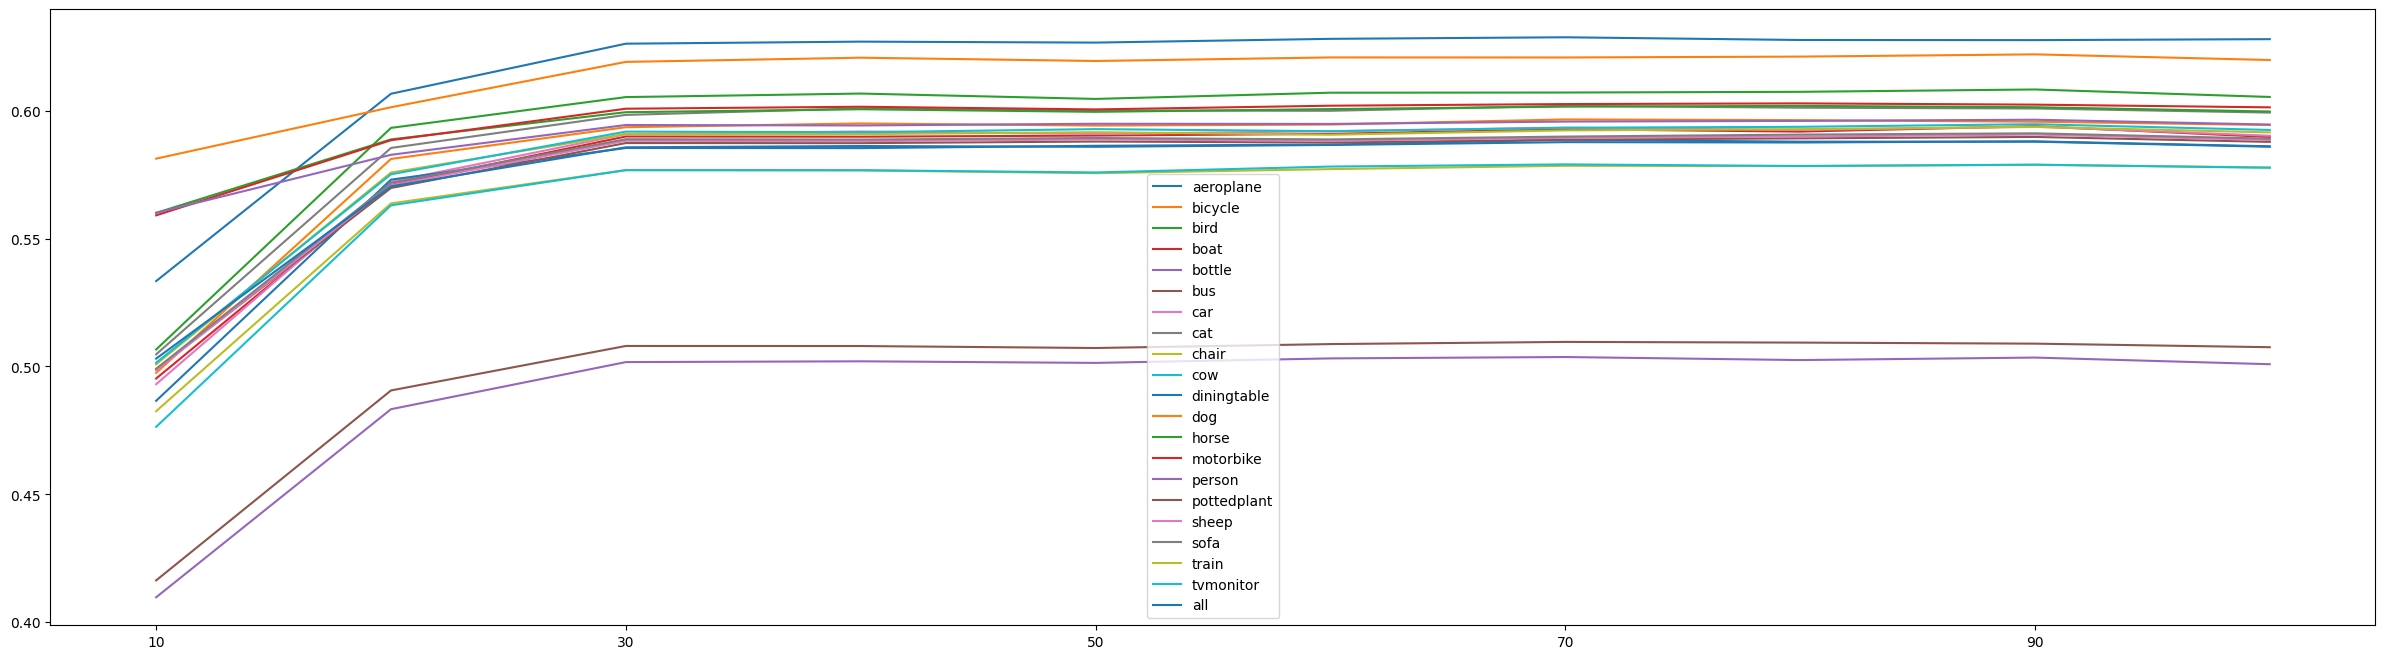

In [83]:
result_table.plot(figsize=(30,8))

<Axes: title={'center': 'resnet34 validation mAP on VOC 2007 test set'}>

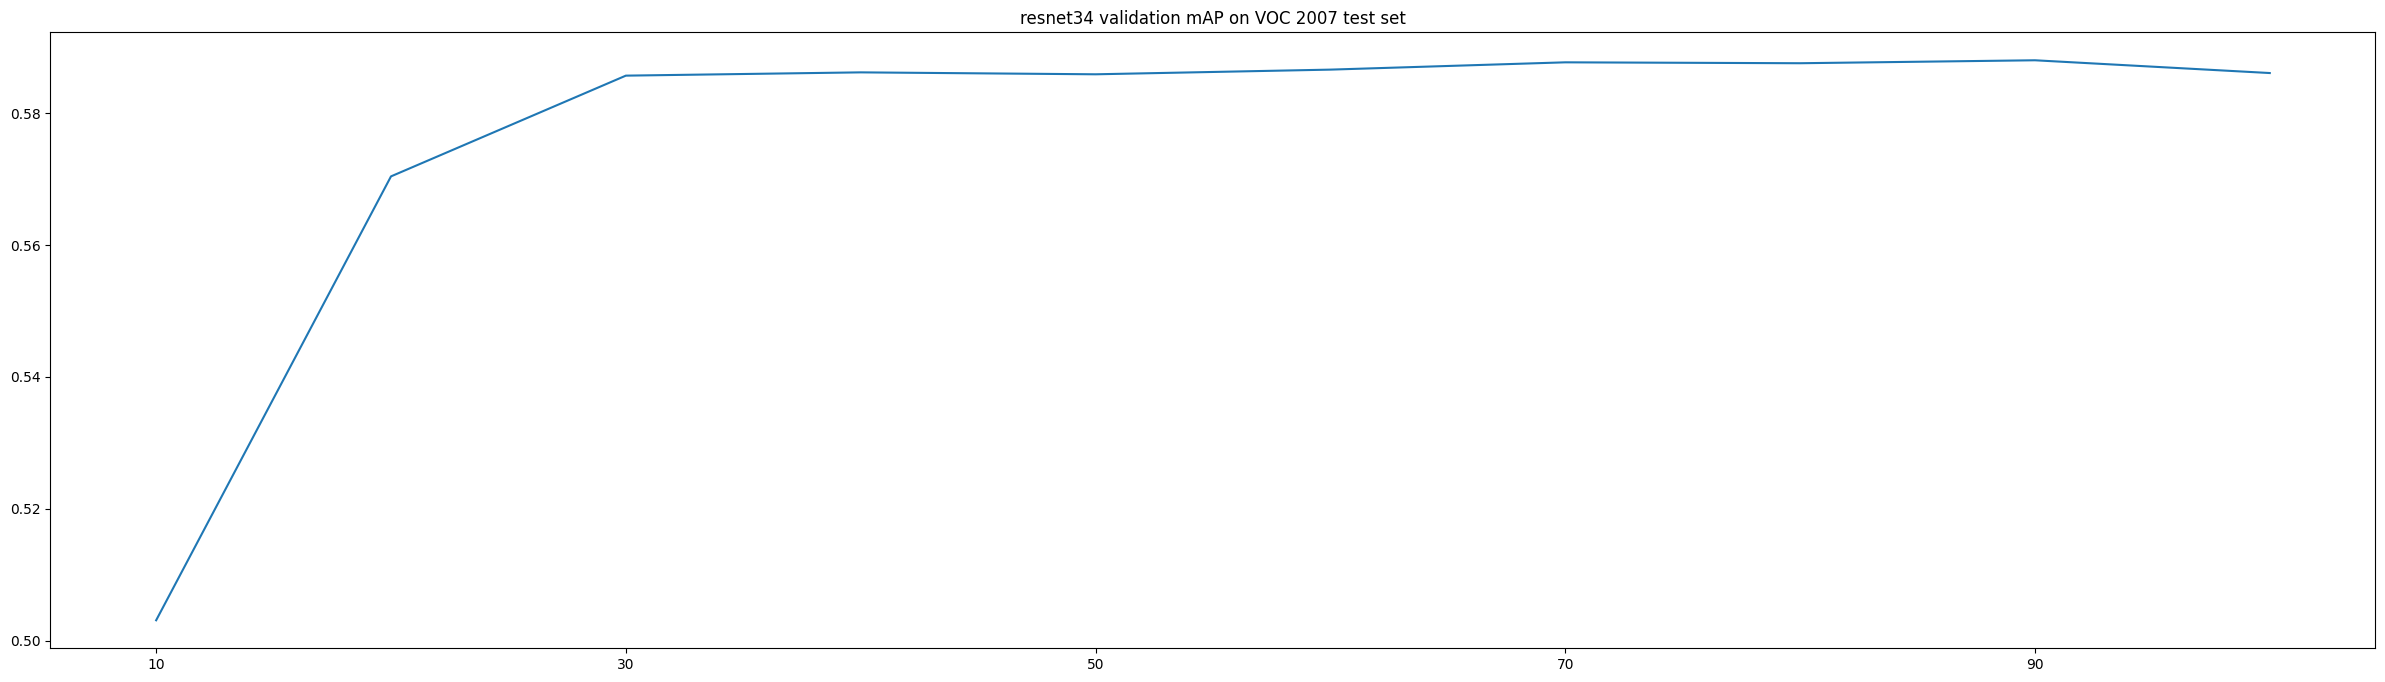

In [84]:
result_table['all'].plot(figsize=(30,8),title=f"{model.foot.network_name} validation mAP on VOC 2007 test set")

# debug

In [ ]:
AP, _ = evaluator.evaluate_detector(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 154/154 [01:22<00:00,  1.86it/s]


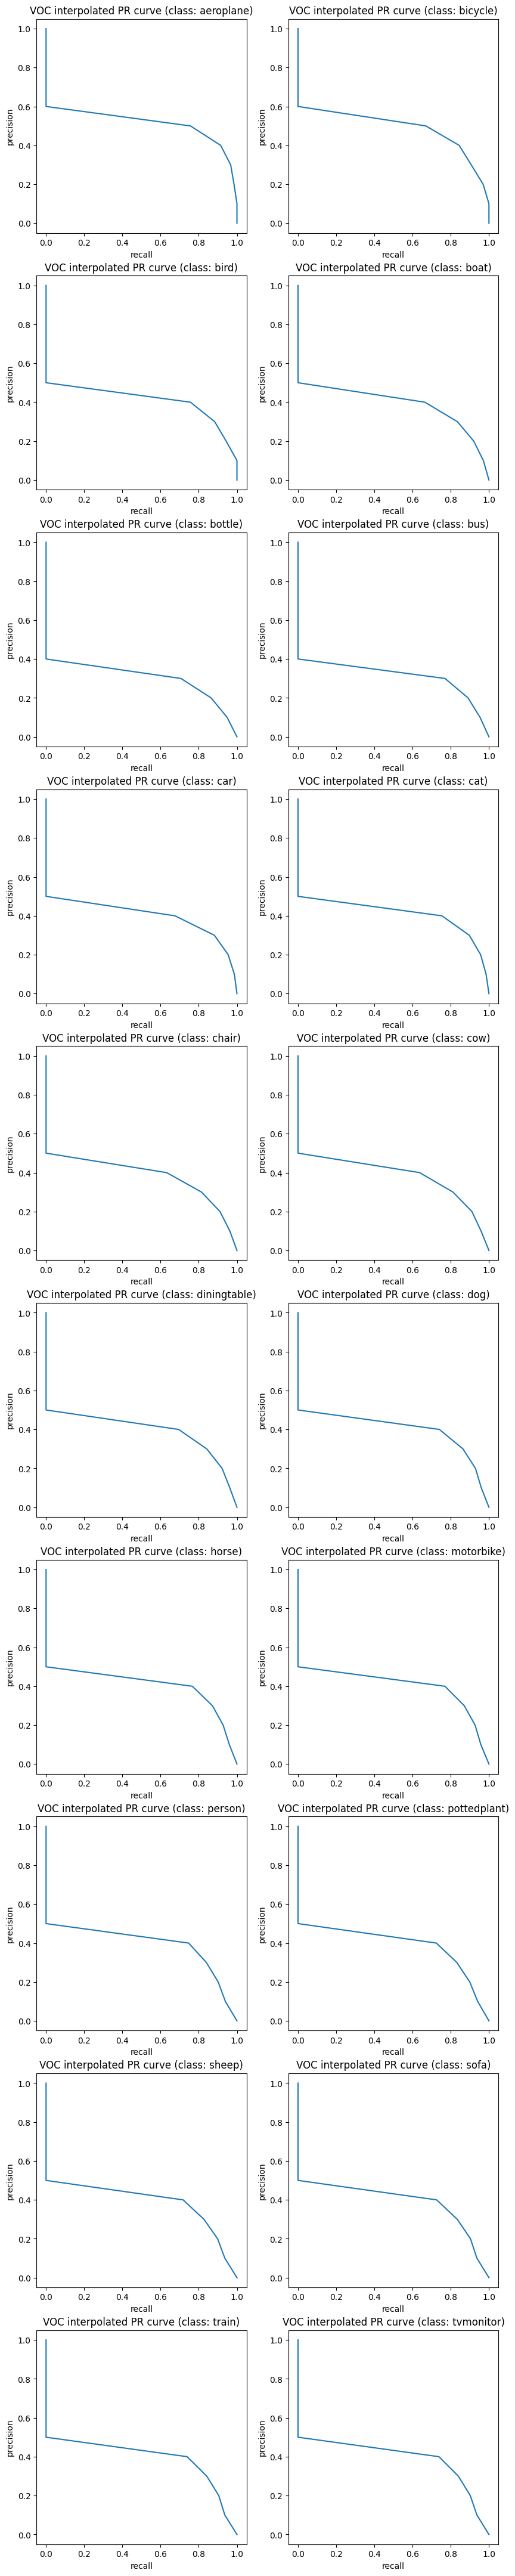

In [ ]:
plt.figure(figsize=(10, 55))
for c_idx, class_name in enumerate(VOC_CLASS_NAMES):
    plt.subplot(len(VOC_CLASS_NAMES) // 2, 2, c_idx+1)
    plt.plot(AP[class_name][0], AP[class_name][1])
    plt.title(f"VOC interpolated PR curve (class: {class_name})")
    plt.xlabel("recall")
    plt.ylabel("precision")

In [ ]:
interest_cls = 'aeroplane'
Iamnotsure = pd.DataFrame({
    'iou': torch.cat([a for a, b, c in debug_map[interest_cls] if a is not None],0).numpy(),
    'prob': torch.cat([b for a, b, c in debug_map[interest_cls] if b is not None],0).numpy(),
    'gt': sum(c for a, b, c in debug_map[interest_cls])
}).sort_values('prob',ascending=False)
Iamnotsure['TP'] = Iamnotsure['iou'].gt(0.5).cumsum()
Iamnotsure['precision'] = Iamnotsure['TP']/np.arange(1,len(Iamnotsure)+1)
Iamnotsure['recall'] = Iamnotsure['TP']/Iamnotsure['gt']
Iamnotsure

,iou,prob,gt,TP,precision,recall
71,0.884566,0.890917,265.0,1,1.000000,0.003774
100,0.955297,0.890582,265.0,2,1.000000,0.007547
142,0.851079,0.879476,265.0,3,1.000000,0.011321
134,0.940841,0.871596,265.0,4,1.000000,0.015094
200,0.811990,0.857263,265.0,5,1.000000,0.018868
...,...,...,...,...,...,...
101,0.518033,0.335952,265.0,190,0.867580,0.716981
58,0.000000,0.321791,265.0,190,0.863636,0.716981
164,0.577316,0.320824,265.0,191,0.864253,0.720755
28,0.000000,0.319813,265.0,191,0.860360,0.720755


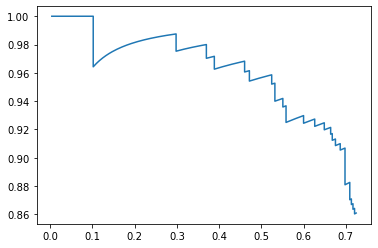

In [ ]:
# plt.ylim(0,1.3)
plt.plot(Iamnotsure['recall'], Iamnotsure['precision'])

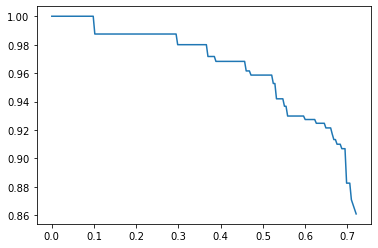

In [ ]:
a,b = all_pr_curve(eval_table[interest_cls]['precision'],eval_table[interest_cls]['recall'])
plt.plot(b, a)

In [ ]:
r18 = pd.read_csv('Final.1e-4/eval.csv',index_col=0)
r34 = pd.read_csv('Final.1e-4.34/eval.csv',index_col=0)

In [ ]:
pd.concat([r18,r34]).loc[['./yolov1.resnet18.150.pth','./yolov1.resnet34.130.pth']].transpose()

,./yolov1.resnet18.150.pth,./yolov1.resnet34.130.pth
aeroplane,0.659695,0.699073
bicycle,0.601857,0.635265
bird,0.528688,0.610817
boat,0.457822,0.517191
bottle,0.199932,0.248924
bus,0.630690,0.716136
car,0.658628,0.670062
cat,0.751293,0.761671
chair,0.216588,0.309187
cow,0.550103,0.604650


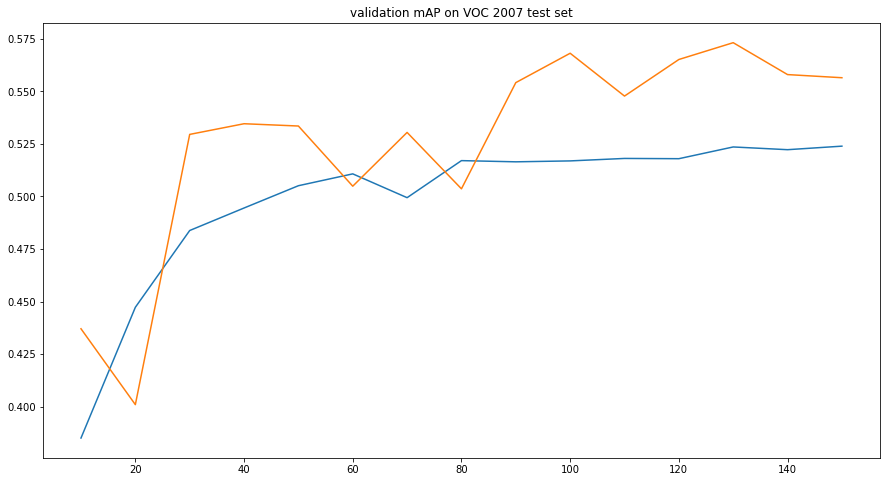

In [ ]:
plt.figure(figsize=(15,8))
plt.title("validation mAP on VOC 2007 test set")
plt.plot(range(10,160,10), r18['all'])
plt.plot(range(10,160,10), r34['all'])